# Estimacion de produccion de Aceite

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

#import sys
#sys.path.append('../serch_tools/')
#import serch_tools as st

from pdpbox import pdp, info_plots
from sklearn.cluster import KMeans
import plotly
import cufflinks

In [187]:
# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [188]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [191]:
prod_mens = pd.read_csv('datos/produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [192]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [193]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [194]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [195]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [197]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [198]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [199]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [200]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [201]:
# tabla (t)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t + 1)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t + 2)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t + 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t + 4)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t + 4)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t + 4)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [202]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
df.columns = ['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4',
              'Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1','Qomes_b_t']

In [203]:
df.shape # numero de registros

(20880, 7)

In [204]:
df['diff_t_6_t_5'] = df.Qomes_b_t_6 - df.Qomes_b_t_5
df['diff_t_5_t_4'] = df.Qomes_b_t_5 - df.Qomes_b_t_4
df['diff_t_4_t_3'] = df.Qomes_b_t_4 - df.Qomes_b_t_3
df['diff_t_3_t_2'] = df.Qomes_b_t_3 - df.Qomes_b_t_2
df['diff_t_2_t_1'] = df.Qomes_b_t_2 - df.Qomes_b_t_1

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [205]:
df['std_t_6_t_1'] = df[['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4','Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1']].std(1)
df['mean_t_6_t_1'] = df[['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4','Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1']].mean(1)
df['median_t_6_t_1'] = df[['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4','Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1']].median(1)
df['min_t_6_t_1'] = df[['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4','Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1']].min(1)
df['max_t_6_t_1'] = df[['Qomes_b_t_6','Qomes_b_t_5','Qomes_b_t_4','Qomes_b_t_3','Qomes_b_t_2','Qomes_b_t_1']].max(1)

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor

In [206]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

In [207]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [208]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [209]:
detenido_mes_anterior = pd.DataFrame(np.where((db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D") > 31, 1, 0), index=db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
detenido_mes_anterior.head()

detenido_mes_antes
Pozo          fecha_produccion                    
MOLOACAN-1004 2002-06-01                         1
              2002-07-01                         0
              2002-08-01                         0
              2002-09-01                         0
              2002-10-01                         0

In [210]:
df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Variables de historico de agua y gas

No se vale meterlas por que vas a tener que estimarlas despues

In [211]:
df_train = df.reset_index()

In [212]:
df_train.shape

(20880, 32)

## Quitamos Outliers

In [213]:
df_train = df_train[df_train.Qomes_b_t > df_train.Qomes_b_t.quantile(0.005)]
df_train = df_train[df_train.Qomes_b_t_1 > df_train.Qomes_b_t_1.quantile(0.001)]
df_train = df_train[df_train.Qomes_b_t_2 > df_train.Qomes_b_t_2.quantile(0.001)]
df_train = df_train[df_train.Qomes_b_t_3 > df_train.Qomes_b_t_3.quantile(0.001)]
df_train = df_train[df_train.Qomes_b_t_4 > df_train.Qomes_b_t_4.quantile(0.001)]
df_train = df_train[df_train.Qomes_b_t_5 > df_train.Qomes_b_t_5.quantile(0.001)]
df_train = df_train[df_train.Qomes_b_t_6 > df_train.Qomes_b_t_6.quantile(0.001)]

In [214]:
df_train = df_train[df_train.Qomes_b_t < df_train.Qomes_b_t.quantile(0.99)]

In [215]:
df_train = df_train[df_train.Qomes_b_t_1 < df_train.Qomes_b_t_1.quantile(0.99)]
df_train = df_train[df_train.Qomes_b_t_2 < df_train.Qomes_b_t_2.quantile(0.99)]
df_train = df_train[df_train.Qomes_b_t_3 < df_train.Qomes_b_t_3.quantile(0.99)]
df_train = df_train[df_train.Qomes_b_t_4 < df_train.Qomes_b_t_4.quantile(0.99)]
df_train = df_train[df_train.Qomes_b_t_5 < df_train.Qomes_b_t_5.quantile(0.99)]
df_train = df_train[df_train.Qomes_b_t_6 < df_train.Qomes_b_t_6.quantile(0.99)]

In [216]:
df_train.reset_index(inplace=True, drop=True)

In [217]:
df_train.shape

(19206, 32)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [218]:
from sklearn.cluster import KMeans

In [219]:
num_cols = ['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1']

In [220]:
df_std = (df_train[num_cols] - df_train[num_cols].mean() )/ df_train[num_cols].std()

In [221]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [222]:
df_train = pd.concat([df_train,pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [223]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [224]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'Qomes_b_t',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster'],
      dtype='object')

In [225]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [226]:
df_train = df_train.merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [227]:
df_train.head()

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,detenido_mes_antes,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud
221,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,10.46,...,0,1,0,0,0,0,0,0,17.985929,-94.370707
222,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,-34.49,...,0,1,0,0,0,0,0,0,17.985929,-94.370707
223,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,24.85,...,0,1,0,0,0,0,0,0,17.985929,-94.370707
224,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,-12.93,...,0,1,0,0,0,0,0,0,17.985929,-94.370707
225,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,4.75,...,0,1,0,0,0,0,0,0,17.985929,-94.370707


In [228]:
df_train.shape

(18806, 41)

# AED

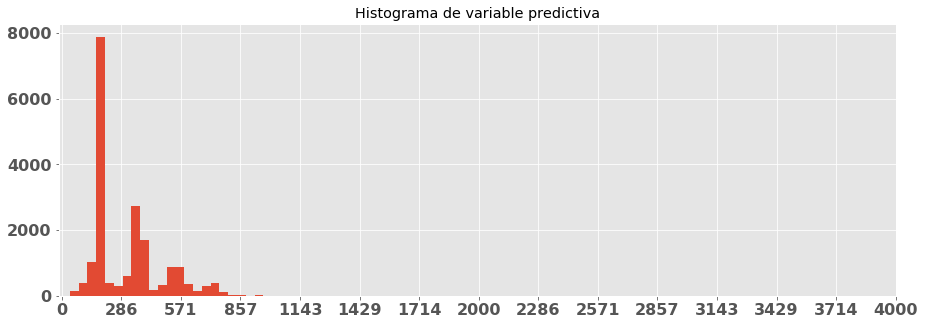

In [229]:
df_train.Qomes_b_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [230]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'Qomes_b_t',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster', 'latitud', 'longitud'],
      dtype='object')

In [231]:
num_cols = ['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5',
       'latitud', 'longitud']

En algun momento dibujaras un mapa aqui

In [232]:
lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

# mas variables

In [233]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'Qomes_b_t',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster', 'latitud', 'longitud'],
      dtype='object')

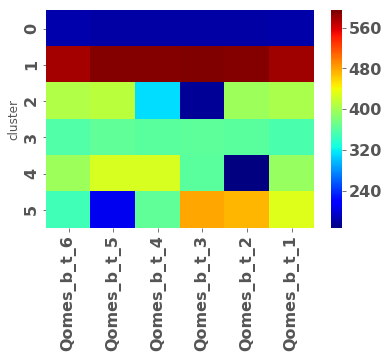

In [234]:
sns.heatmap(df_train.groupby('cluster')[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].mean(),cmap='jet')

# Entrenamiento

In [235]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'Qomes_b_t',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster', 'latitud', 'longitud'],
      dtype='object')

In [236]:
num_cols =['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1',
           'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 
       'latitud', 'longitud']

In [237]:
#ML preprocessing
from sklearn.model_selection import train_test_split
def train_test_valid_split(df, x_cols, y_col):
    
    x_train_test, x_valid, y_train_test, y_valid = train_test_split(
    df[x_cols],
    df[y_col],
    test_size=0.1,
    random_state=8)

    x_train, x_test, y_train, y_test = train_test_split(x_train_test, 
                                                    y_train_test,
                                                    test_size = 0.2,
                                                    random_state=10)
    
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [238]:
x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(df_train, num_cols, 'Qomes_b_t')

In [240]:
x_valid.head()

,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,diff_t_6_t_5,diff_t_5_t_4,diff_t_4_t_3,diff_t_3_t_2,...,month_12,detenido_mes_antes,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,latitud,longitud
7359,171.53,153.38,171.54,147.86,165.92,176.75,18.15,-18.16,23.68,-18.06,...,0,0,1,0,0,0,0,0,17.992989,-94.362479
15626,503.02,521.73,488.29,366.02,122.70,121.82,-18.71,33.44,122.27,243.32,...,0,0,0,0,0,0,1,0,18.005602,-94.341469
8631,180.66,180.96,178.02,185.31,171.14,166.79,-0.30,2.94,-7.29,14.17,...,0,0,1,0,0,0,0,0,18.013240,-94.347007
16053,499.04,377.23,355.77,364.82,372.61,411.99,121.81,21.46,-9.05,-7.79,...,0,0,0,0,0,1,0,0,18.028160,-94.329587
18226,695.16,695.08,704.81,681.59,714.93,729.28,0.08,-9.73,23.22,-33.34,...,0,0,0,1,0,0,0,0,17.962783,-94.376283


In [239]:
x_train.shape

(13540, 37)

In [65]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.8
params['num_leaves'] = 25
params['min_data'] = 10
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 100, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[8464]	valid_0's l1: 26.4942


In [64]:
clf.num_trees()

8464

# Evaluacion

In [66]:
y_pred = clf.predict(x_valid)

In [68]:
#ML Evaluation
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred):
    
    print("R*2: %1.4f" % metrics.r2_score(y_real,y_pred))
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.3f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.3f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))

In [69]:
report_evaluation_regression(y_valid, y_pred)

R*2: 0.8671
MEA: 27.2530
MSE 3681.473
RMSE 60.675


In [71]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi1,ma1],[mi2,ma2], linestyle='--', color='navy')
    plt.ylabel('Y_real')
    plt.xlabel('Y_estimada')

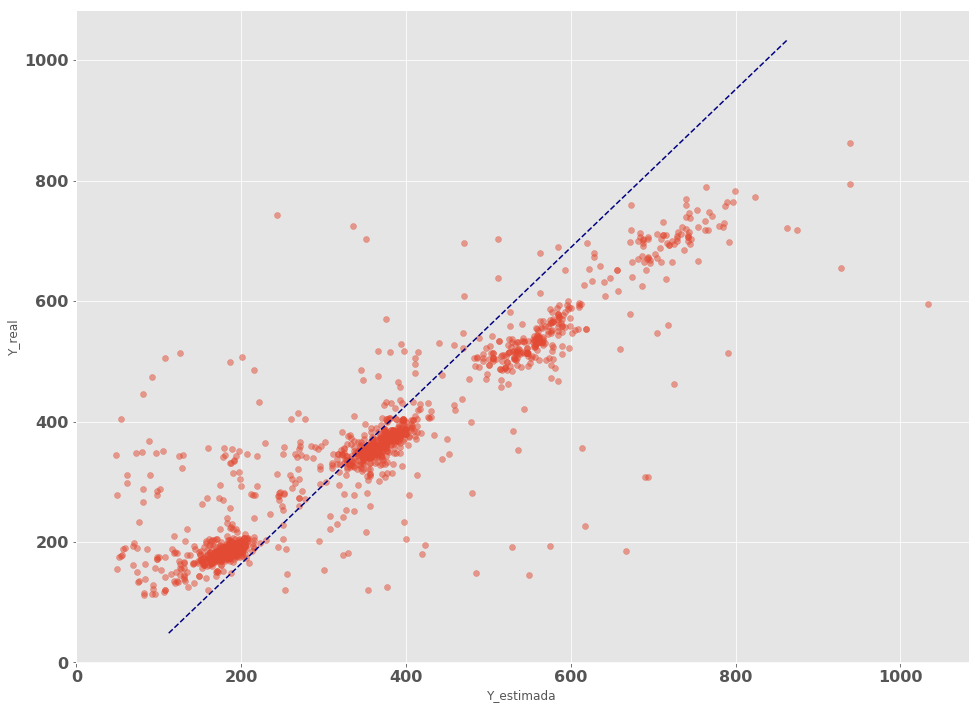

In [72]:
yy_plot(y_valid, y_pred)

## Residuos

In [73]:
res = (y_valid - y_pred) / y_valid

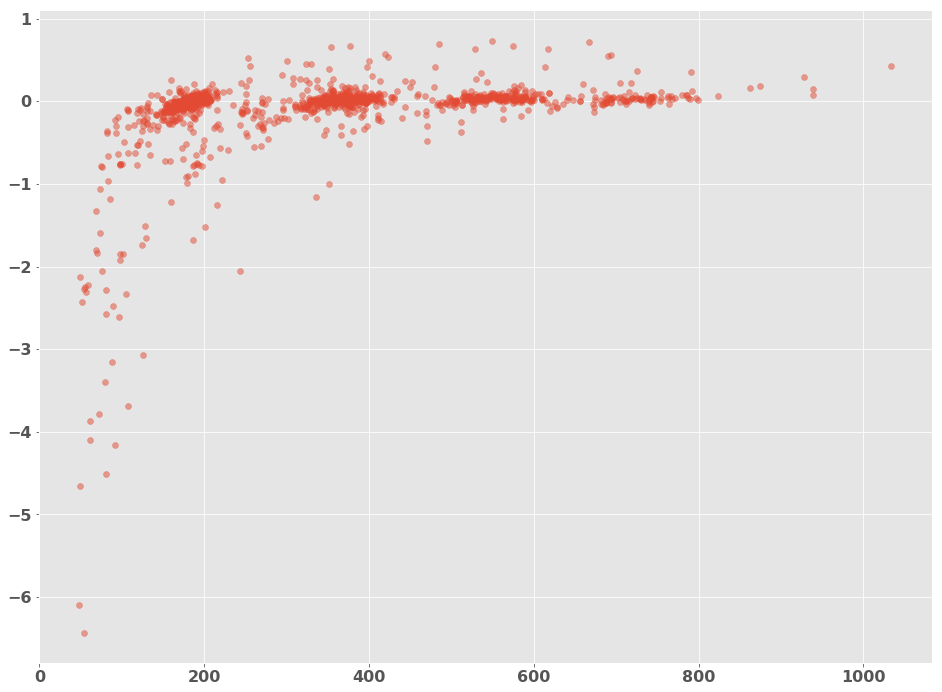

In [74]:
plt.scatter(y_valid, res, alpha=0.5)

In [75]:
res.median() * 100

0.8987088908308483

In [76]:
res.mean() * 100

-6.7304774838831145

In [77]:
df_train.loc[res[res<-5].index]

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,detenido_mes_antes,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud
13154,MOLOACAN-624,2006-08-01,547.88,485.33,547.84,463.64,302.63,18.87,54.30,62.55,...,0,0,0,1,0,0,0,2,18.018731,-94.334423
14109,MOLOACAN-640,2004-04-01,353.91,354.51,347.55,365.69,349.65,331.05,48.45,-0.60,...,0,1,0,0,0,0,0,0,18.014402,-94.341071


In [78]:
res[res<-5]

13154   -6.433411
14109   -6.092295
Name: Qomes_b_t, dtype: float64

## Autocorrelacion

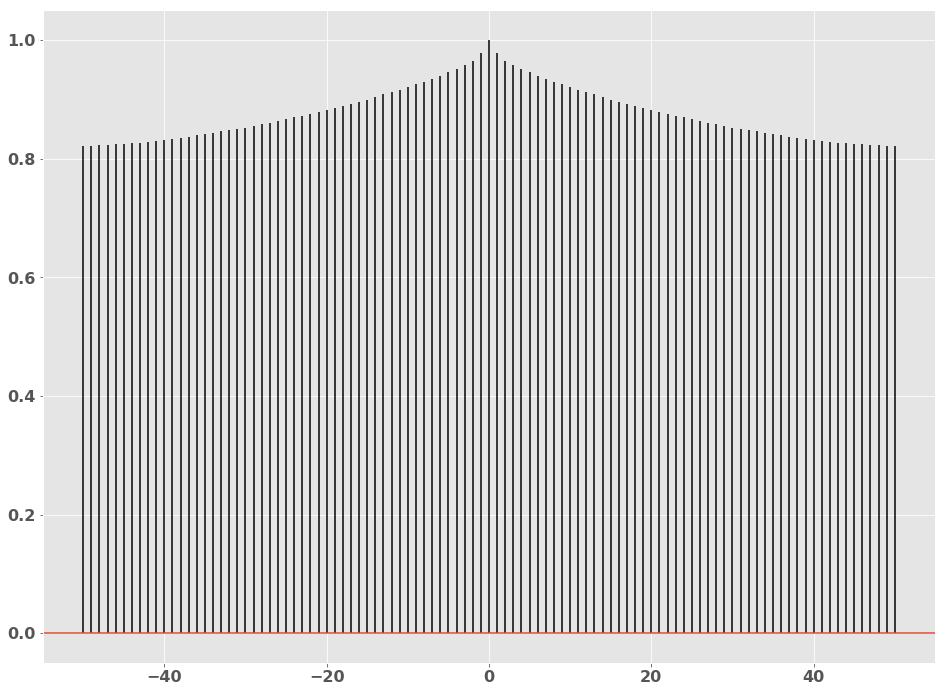

In [79]:
plt.xcorr(df_train.Qomes_b_t, df_train.Qomes_b_t,maxlags=50, usevlines=1)
plt.show()

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

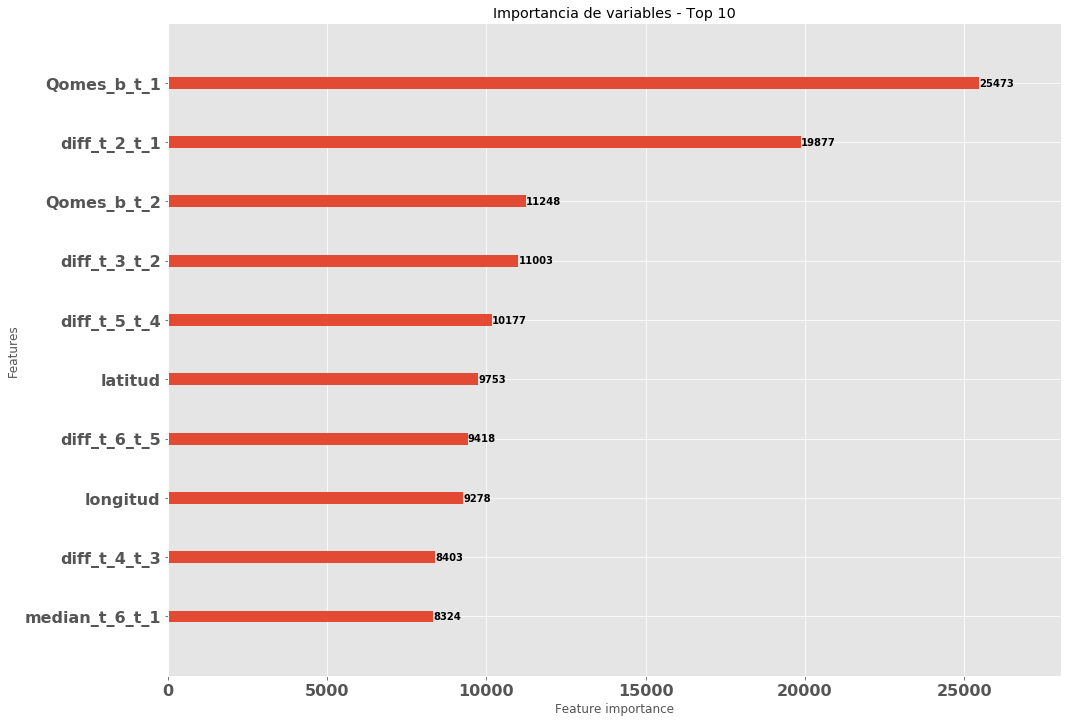

In [80]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [82]:
def shap_shap(clf, x_valid):
    explainer = shap.TreeExplainer(clf)
    return explainer, explainer.shap_values(x_valid)

In [81]:
explainer, shap_values = shap_shap(clf, x_valid)

AttributeError: module 'serch_tools' has no attribute 'shap_shap'

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [83]:
a = pd.DataFrame(clf.feature_importance(),index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [84]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

NameError: name 'shap_values' is not defined

# Check de pozos aleatorios

In [85]:
idx = df_train.Pozo.sample(10)

In [86]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Qomes_b_t.first().index

In [87]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Qomes_b_t.first().unstack(0)

In [88]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [89]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

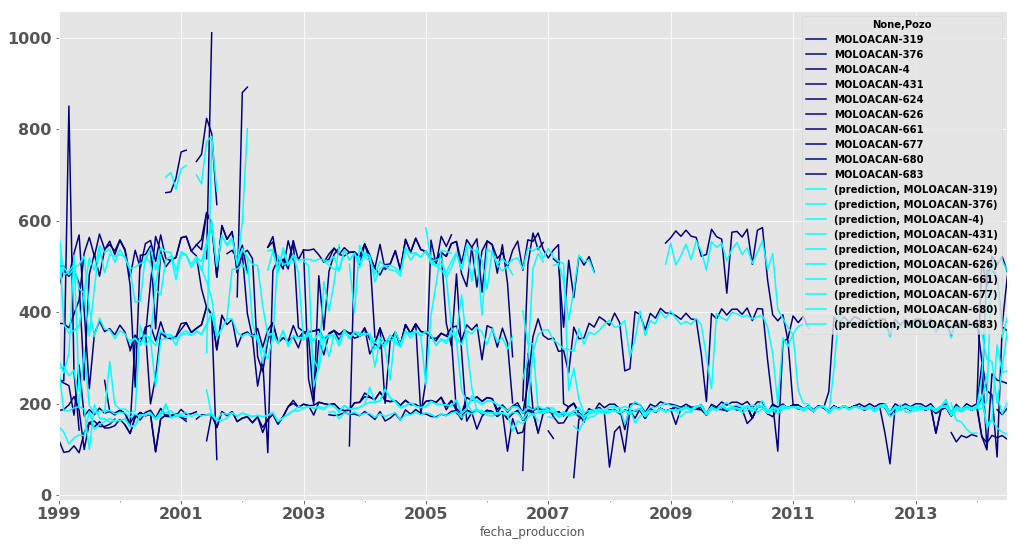

In [90]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [ ]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [91]:
preds = clf.predict(df_train[num_cols])
real = df_train.Qomes_b_t

In [92]:
df_train['prediction'] = preds

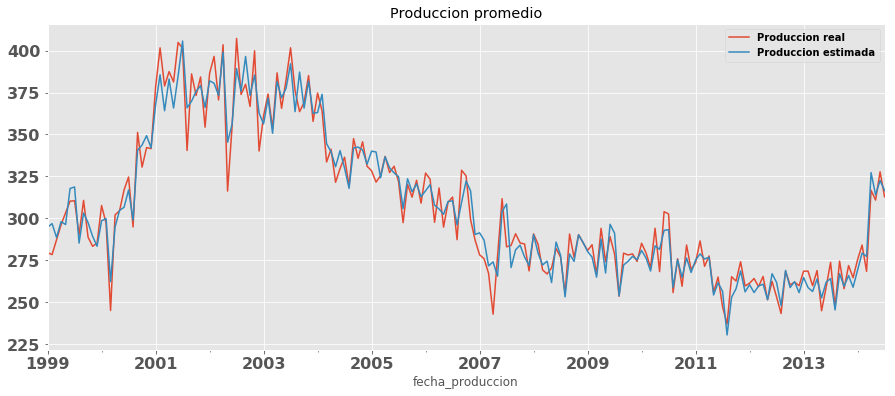

In [93]:
df_train.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Generador de serie de tiempo

In [3]:
from sklearn.externals import joblib
# save model
# load model
gbm_pickle = joblib.load('lgb.pkl')

In [5]:
gbm_pickle.

array([10804,  8389, 10225, 11044, 15064, 30544, 14610, 15734, 12987,
       16474, 28464, 11907,  8077, 10009,  8464,  9494,  2734,  5789,
        3133,   867,  1343,  1730,  1421,   225,  2498,   393,  2594,
        1586,  4457,   256,   453,   237,   168,   230,    74, 14550,
       14012])

In [6]:
num_cols =['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4', 'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'diff_t_6_t_5', 
           'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
           'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
           'detenido_mes_antes', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'latitud', 'longitud']

In [94]:
df_train.head()

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction
221,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,10.46,...,0,1,0,0,0,0,1,17.985929,-94.370707,180.627594
222,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,-34.49,...,0,1,0,0,0,0,1,17.985929,-94.370707,180.134310
223,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,24.85,...,0,1,0,0,0,0,1,17.985929,-94.370707,178.277909
224,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,-12.93,...,0,1,0,0,0,0,1,17.985929,-94.370707,187.970227
225,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,4.75,...,0,1,0,0,0,0,1,17.985929,-94.370707,197.399264


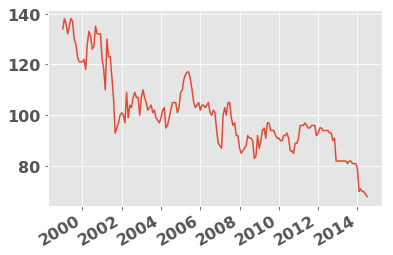

In [154]:
df_train.fecha_produccion.value_counts().plot()

In [96]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
#df_simul.drop(['Qomes_b_t_log','cluster'], 1, inplace=True)
df_simul['y_real'] = df_simul.Qomes_b_t
# se selecciono aleatoriamente

In [97]:
df_simul.columns

Index(['Pozo', 'fecha_produccion', 'Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
       'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1', 'Qomes_b_t',
       'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2',
       'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'max_t_6_t_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'detenido_mes_antes', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster', 'latitud', 'longitud', 'prediction', 'y_real'],
      dtype='object')

In [105]:
df_simul.head()

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19.00,...,1,0,0,0,0,1,17.965461,-94.384466,195.023480,187.99
1,MOLOACAN-836,1999-02-01,150.43,164.86,162.94,174.67,167.18,187.99,184.67,-14.43,...,1,0,0,0,0,1,17.965461,-94.384466,184.016083,184.67
2,MOLOACAN-836,1999-03-01,164.86,162.94,174.67,167.18,187.99,184.67,184.96,1.92,...,1,0,0,0,0,1,17.965461,-94.384466,179.810032,184.96
3,MOLOACAN-836,1999-05-01,174.67,167.18,187.99,184.67,184.96,25.30,381.54,7.49,...,1,0,0,0,0,1,17.965461,-94.384466,346.370887,381.54
4,MOLOACAN-836,1999-06-01,167.18,187.99,184.67,184.96,25.30,381.54,398.67,-20.81,...,0,0,1,0,0,3,17.965461,-94.384466,374.750904,398.67


In [98]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df['Qomes_b_t_6'] - df['Qomes_b_t_5']
    df['diff_t_5_t_4'] = df['Qomes_b_t_5'] - df['Qomes_b_t_4']
    df['diff_t_4_t_3'] = df['Qomes_b_t_4'] - df['Qomes_b_t_3']
    df['diff_t_3_t_2'] = df['Qomes_b_t_3'] - df['Qomes_b_t_2']
    df['diff_t_2_t_1'] = df['Qomes_b_t_2'] - df['Qomes_b_t_1']

    df['std_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].std(1)
    df['mean_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].mean(1)
    df['median_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].median(1)
    df['min_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].min(1) 
    df['max_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].max(1)
    return df

In [113]:
df_simulation = pd.DataFrame(df_simul.iloc[0]).T.reset_index(drop=True)
df_simulation = df_simulation.append(df_simul.iloc[1])
df_simulation

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01 00:00:00,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19,...,1,0,0,0,0,1,17.9655,-94.3845,195.023,187.99
1,MOLOACAN-836,1999-02-01 00:00:00,150.43,164.86,162.94,174.67,167.18,187.99,184.67,-14.43,...,1,0,0,0,0,1,17.9655,-94.3845,184.016,184.67


In [115]:
df_simulation=df_simulation.set_value(1,'Qomes_b_t', df_simulation.loc[0,'prediction'])
df_simulation

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01 00:00:00,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19,...,1,0,0,0,0,1,17.9655,-94.3845,195.023,187.99
1,MOLOACAN-836,1999-02-01 00:00:00,150.43,164.86,162.94,174.67,167.18,187.99,195.023,-14.43,...,1,0,0,0,0,1,17.9655,-94.3845,184.016,184.67


In [116]:
gen_cols(df_simulation)

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01 00:00:00,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19,...,1,0,0,0,0,1,17.9655,-94.3845,195.023,187.99
1,MOLOACAN-836,1999-02-01 00:00:00,150.43,164.86,162.94,174.67,167.18,187.99,195.023,-14.43,...,1,0,0,0,0,1,17.9655,-94.3845,184.016,184.67


In [ ]:
# simulacion de prediccion

In [121]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
df_simul.head(5)

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster,latitud,longitud,prediction
0,MOLOACAN-836,1999-01-01,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19.00,...,0,1,0,0,0,0,1,17.965461,-94.384466,195.023480
1,MOLOACAN-836,1999-02-01,150.43,164.86,162.94,174.67,167.18,187.99,184.67,-14.43,...,0,1,0,0,0,0,1,17.965461,-94.384466,184.016083
2,MOLOACAN-836,1999-03-01,164.86,162.94,174.67,167.18,187.99,184.67,184.96,1.92,...,0,1,0,0,0,0,1,17.965461,-94.384466,179.810032
3,MOLOACAN-836,1999-05-01,174.67,167.18,187.99,184.67,184.96,25.30,381.54,7.49,...,0,1,0,0,0,0,1,17.965461,-94.384466,346.370887
4,MOLOACAN-836,1999-06-01,167.18,187.99,184.67,184.96,25.30,381.54,398.67,-20.81,...,0,0,0,1,0,0,3,17.965461,-94.384466,374.750904


In [305]:
df_simulation

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01 00:00:00,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19,...,1,0,0,0,0,0,17.9655,-94.3845,195.861,187.99
1,MOLOACAN-836,1999-02-01 00:00:00,150.43,164.86,162.94,174.67,167.18,187.99,195.861,-14.43,...,1,0,0,0,0,0,17.9655,-94.3845,185.202,184.67
2,MOLOACAN-836,1999-03-01 00:00:00,164.86,162.94,174.67,167.18,187.99,195.861,185.202,1.92,...,1,0,0,0,0,0,17.9655,-94.3845,178.961,184.96


In [306]:
df_simulation = df_simulation.append(df_simul.iloc[3])
prediccion = clf.predict(df_simul.iloc[2:3][num_cols])[0]
print('estimacion %1.3f' %prediccion)
df_simulation.set_value(3,'Qomes_b_t', prediccion)
df_simulation.set_value(3,'Qomes_b_t_1', df_simulation.loc[2,'Qomes_b_t'])
df_simulation.set_value(3,'Qomes_b_t_2', df_simulation.loc[2,'Qomes_b_t_1'])
df_simulation = gen_cols(df_simulation)

estimacion 178.961


In [307]:
df_simulation

,Pozo,fecha_produccion,Qomes_b_t_6,Qomes_b_t_5,Qomes_b_t_4,Qomes_b_t_3,Qomes_b_t_2,Qomes_b_t_1,Qomes_b_t,diff_t_6_t_5,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,latitud,longitud,prediction,y_real
0,MOLOACAN-836,1999-01-01 00:00:00,169.43,150.43,164.86,162.94,174.67,167.18,187.99,19,...,1,0,0,0,0,0,17.9655,-94.3845,195.861,187.99
1,MOLOACAN-836,1999-02-01 00:00:00,150.43,164.86,162.94,174.67,167.18,187.99,195.861,-14.43,...,1,0,0,0,0,0,17.9655,-94.3845,185.202,184.67
2,MOLOACAN-836,1999-03-01 00:00:00,164.86,162.94,174.67,167.18,187.99,195.861,185.202,1.92,...,1,0,0,0,0,0,17.9655,-94.3845,178.961,184.96
3,MOLOACAN-836,1999-05-01 00:00:00,174.67,167.18,187.99,184.67,195.861,185.202,178.961,7.49,...,1,0,0,0,0,0,17.9655,-94.3845,375.726,381.54


In [4]:
import pandas as pd
import numpy as np

In [91]:
n_pred=3

In [127]:
y_predic=pd.DataFrame(np.array([10,20,30]),columns=['y_pred'])
y_predic

,y_pred
0,10
1,20
2,30


In [182]:
df2 = pd.DataFrame(np.array([ [10,1,2,3],[1, 2, 3,4], [2, 3, 4,5]]),
...                    columns=['t-3','t-2', 't-1', 't'])
df2

,t-3,t-2,t-1,t
0,10,1,2,3
1,1,2,3,4
2,2,3,4,5


In [183]:
df3=df2
for i in range(n_pred):
    for j in range(df3.shape[1]-1):
        # recorrer valores
        df3.iloc[0,j] = df3.iloc[0,j+1]
    # colocar el valor de la predicción
    valor=y_predic.loc[i,'y_pred']
    df3.iloc[0,df3.shape[1]-1]=valor
    # guardar registro
    df4=pd.concat([df3.loc[:0],df3],ignore_index=True)
    #df4.drop(df4.index[0])
    df3=df4
    #df3=df3.drop(0).reset_index(drop=True)
    print(df3)

   t-3  t-2  t-1   t
0    1    2    3  10
1    1    2    3  10
2    1    2    3   4
3    2    3    4   5
   t-3  t-2  t-1   t
0    2    3   10  20
1    2    3   10  20
2    1    2    3  10
3    1    2    3   4
4    2    3    4   5
   t-3  t-2  t-1   t
0    3   10   20  30
1    3   10   20  30
2    2    3   10  20
3    1    2    3  10
4    1    2    3   4
5    2    3    4   5


In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

In [185]:
df3.shape

(6, 4)